[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jfcrenshaw/pzflow/blob/main/examples/error_convolution_demo.ipynb)

If running in Colab, to switch to GPU, go to the menu and select Runtime -> Change runtime type -> Hardware accelerator -> GPU.

In addition, uncomment and run the following code:

In [1]:
# !pip install pzflow

------------------
## Error convolution demo

This notebook demonstrates how to train a flow on data that has errors/uncertainties, as well as convolving those errors in log_prob and posterior calculations.
We will use the two moons example from [intro.ipynb](https://github.com/jfcrenshaw/pzflow/blob/main/examples/intro.ipynb) again.

In [1]:
from pzflow import Flow
from pzflow.bijectors import RollingSplineCoupling, Chain, Scale
from pzflow.examples import two_moons_data

import jax.numpy as np
import matplotlib.pyplot as plt

First let's load some example data. It's the familiar two moons data set from scikit-learn, loaded in a Pandas DataFrame, which is the data format `pzflow` uses on the user-end. We will also add columns for $x$ and $y$ errors - let's set them at the 10% level.

In [2]:
# load the data
data = two_moons_data()
# add 10% errors
data["x_err"] = 0.10 * np.abs(data["x"].values)
data["y_err"] = 0.10 * np.abs(data["y"].values)
data

,x,y,x_err,y_err
0,-1.026942,1.410649,0.102694,0.141065
1,0.814149,-1.365693,0.081415,0.136569
2,1.718791,0.362482,0.171879,0.036248
3,0.677510,-1.685869,0.067751,0.168587
4,1.060328,-1.363168,0.106033,0.136317
...,...,...,...,...
9995,-1.121514,1.657424,0.112151,0.165742
9996,-0.994531,1.445759,0.099453,0.144576
9997,1.170882,-1.276065,0.117088,0.127606
9998,1.061871,-1.318802,0.106187,0.131880


Notice how I saved the errors in columns with the suffix "_err".
Anytime you tell `pzflow` to convolve errors (see below), it will look for columns with "_err" suffixes.
If it can't find an error column for a certain variable, it will assume that variable has zero error.
It is also important to know that `pzflow` assumes these are Gaussian errors!

Also, note that I didn't actually add the Gausian noise to the $x$ and $y$ variables themselves.
This is just so we can clearly see the effects of convolving errors below.
The initial data will be noiseless, but since we will convolve errors during training, the samples from the trained flow will be noisy.

Here is the noiseless data:

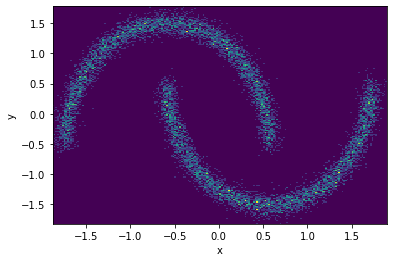

In [3]:
plt.hist2d(data['x'], data['y'], bins=200)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Now we will build the same normalizing flow that we built in [intro.ipynb](https://github.com/jfcrenshaw/pzflow/blob/main/examples/intro.ipynb).

In [4]:
# create the bijector
bijector = RollingSplineCoupling(nlayers=2)

# create the normalizing flow
flow = Flow(("x", "y"), bijector)

Now we can train our normalizing flow.
This time, we will set `sample_errs=True`.
This means that during each epoch of training, we will resample the training set from the Gaussian distributions set by `x_err` and `y_err`.

In [5]:
%%time
losses = flow.train(data, sample_errs=True, verbose=True)

Training 50 epochs 
Loss:
(0) 2.7930
(1) 2.5093
(3) 2.0902
(5) 1.8075
(7) 1.7339
(9) 1.6500
(11) 1.5886
(13) 1.5492
(15) 1.5419
(17) 1.5188
(19) 1.5298
(21) 1.5158
(23) 1.4924
(25) 1.4952
(27) 1.4651
(29) 1.4774
(31) 1.4628
(33) 1.4646
(35) 1.4734
(37) 1.4865
(39) 1.4760
(41) 1.4576
(43) 1.4413
(45) 1.4525
(47) 1.4611
(49) 1.4530
(50) 1.4618
CPU times: user 3min 25s, sys: 16min 7s, total: 19min 32s
Wall time: 35.1 s


Now let's plot the training losses to make sure everything looks like we expect it to...

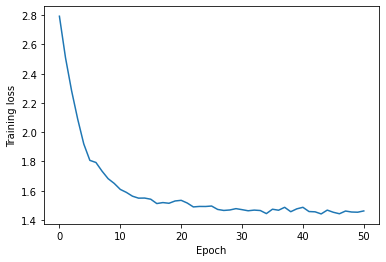

In [6]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Training loss")
plt.show()

Perfect!

Now we can draw samples from the flow, using the `sample` method.

In [7]:
samples = flow.sample(10000, seed=0)

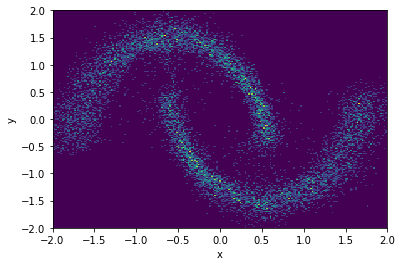

In [8]:
plt.hist2d(samples['x'], samples['y'], bins=200, range=((-2,2),(-2,2)))
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Notice how the learned distribution is noisy - that is because we resampled the training set from the Gaussian error distributions on each epoch of training.
In particular, notice how the noise increases as the magnitude of $x$ and $y$ increases - this is exactly what we expected by setting the error of each to 10% of the true value.

We can also calculate posteriors with error convolution by setting the `nsamples` parameter.
E.g. setting `nsamples=100` tells the posterior method to draw 100 samples from the Gaussian error distribution for each galaxy, calculate posteriors for each of those samples, and then average over the samples.

Below, we will select one galaxy and calculate the posterior for various values of `nsamples`.

In [9]:
galaxy = data[:1]
grid = np.arange(-2, 2.02, 0.02)
pdfs = dict()
for nsamples in [1, 10, 100, 1000, 10000]:
    pdfs[nsamples] = flow.posterior(galaxy, column="x", grid=grid, nsamples=nsamples, seed=0)

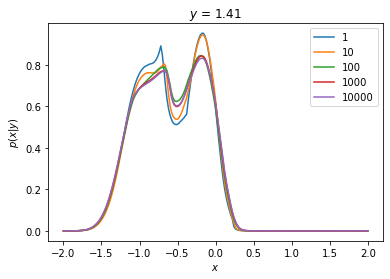

In [11]:
for i, pdf in pdfs.items():
    plt.plot(grid, pdf[0], label=i)
plt.legend()
plt.title(f"$y$ = {data['y'][0]:.2f}")
plt.xlabel("$x$")
plt.ylabel("$p(x|y)$")
plt.show()

We can see how drawing more samples in the error convolution smooths out the posterior as you might expect.

Note that the `log_prob` method works identically.